In [1]:
# Settings
SPLIT = -1
NUM_OF_CLASSES = 35
IMAGE_SIZE_REDUCE_FACTOR = 3

# Hyperparams
BATCH_SIZE = 16
LEARNING_RATE = 0.0001
DROPOUT = 0.5

# DB Hyperparams
NUM_DBS = 4
NUM_LAYERS_PER_DB = 3
NUM_FILTERS_PER_LAYER_OF_DB = 4

In [2]:
# Load Ontology
import pandas as pd

ontology = pd.read_csv("Rellis-3D/ontology.csv")[["class_name", "output_value", "display_color"]].values.tolist()
colors = {v[0]: v[2] for v in ontology}
ontology = {v[0]: v[1] for v in ontology}

# Remove extra classes
del ontology["void"]
# del ontology["dirt"]
del ontology["uphill"]
del ontology["downhill"]

# Process colors
colors = {c: (int(colors[c][1:3], 16), int(colors[c][3:5], 16), int(colors[c][5:7], 16)) for c in ontology.keys()}

# Convert ontology to color map
ontology_labels = list(ontology.keys())
print(ontology)
ontology = [i in ontology.values() for i in range(NUM_OF_CLASSES)]
print(ontology)

print(ontology_labels)
NUM_OF_CLASSES = ontology.count(True)

{'dirt': 1, 'grass': 3, 'tree': 4, 'pole': 5, 'water': 6, 'sky': 7, 'vehicle': 8, 'object': 9, 'asphalt': 10, 'building': 12, 'log': 15, 'person': 17, 'fence': 18, 'bush': 19, 'concrete': 23, 'barrier': 27, 'puddle': 31, 'mud': 33, 'rubble': 34}
[False, True, False, True, True, True, True, True, True, True, True, False, True, False, False, True, False, True, True, True, False, False, False, True, False, False, False, True, False, False, False, True, False, True, True]
['dirt', 'grass', 'tree', 'pole', 'water', 'sky', 'vehicle', 'object', 'asphalt', 'building', 'log', 'person', 'fence', 'bush', 'concrete', 'barrier', 'puddle', 'mud', 'rubble']


In [3]:
# Load pre-downsized images
import numpy as np

files = "Processed Data/"

with np.load(files + "%s_%d.npz" % ("train", SPLIT)) as data:
    # x_train, y_train = data["img_depth_ds"].astype(np.float16), data["img_oh_ds"].astype(np.float16)
    x_train, y_train = data["img_ds"].astype(np.float16), data["img_oh_ds"].astype(np.float16)

with np.load(files + "%s_%d.npz" % ("val", SPLIT)) as data:
    # x_val, y_val = data["img_depth_ds"].astype(np.float16), data["img_oh_ds"].astype(np.float16)
    x_val, y_val = data["img_ds"].astype(np.float16), data["img_oh_ds"].astype(np.float16)

In [4]:
import tensorflow as tf

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

2023-12-15 08:37:39.791554: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-15 08:37:39.834045: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 08:37:40.406317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# Create a distribution strategy
# https://www.tensorflow.org/guide/distributed_training

# dist_strategy = tf.distribute.experimental.ParameterServerStrategy(tf.distribute.cluster_resolver.TFConfigClusterResolver(), )
dist_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2023-12-15 08:37:41.202361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22254 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:18:00.0, compute capability: 8.9
2023-12-15 08:37:41.202895: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22451 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


In [6]:
# Create pre-defined layers
from tensorflow.keras import layers


def create_dense_block(x, num_of_layers, num_filters, kernel_size=5):
    output_layers = [x]
    for l in range(num_of_layers):
        x = layers.Conv2D(num_filters, kernel_size, activation="elu", padding="same")(x)
        output_layers.append(x)
        x = layers.Concatenate()(output_layers)
        x = layers.Dropout(DROPOUT)(x)
    return x

def create_transistion_down(x, layer_size_change, num_filters=None):
    if num_filters:
        x = layers.Conv2D(num_filters, 1, activation="elu", padding="same")(x)
    
    return layers.MaxPool2D(layer_size_change)(x)

def create_transistion_up(x, layer_size_change, num_filters):
    return layers.Conv2DTranspose(num_filters, 1, strides=layer_size_change, activation="elu", padding="same")(x)
    

In [7]:
y_val.shape

(979, 400, 640, 19)

In [8]:
# Create model
from tensorflow.keras import models, optimizers, metrics

# Keep track for skip connections and other things
skip_connections = []
previous_filters = [NUM_LAYERS_PER_DB * NUM_FILTERS_PER_LAYER_OF_DB]

# Num of filters: 4 (layers) * 32 (idk) + 64 (previous filters)
# Should prob figure out why this is

# https://stackoverflow.com/a/71310084 says to put this here
with dist_strategy.scope():
    model_in = layers.Input(shape=x_train[0].shape)
    x = layers.Conv2D(previous_filters[-1], 9, activation="elu", padding="same")(model_in)

    for i in range(NUM_DBS):
        previous_filters.append(NUM_LAYERS_PER_DB * NUM_FILTERS_PER_LAYER_OF_DB + previous_filters[-1])
        x = create_dense_block(x, NUM_LAYERS_PER_DB, previous_filters[-1])
        skip_connections.append(x)
        x = create_transistion_down(x, 2, num_filters=(previous_filters[-1]))


    previous_filters.append(NUM_LAYERS_PER_DB * NUM_FILTERS_PER_LAYER_OF_DB + previous_filters[-1])
    x = create_dense_block(x, NUM_LAYERS_PER_DB, previous_filters[-1])
    del previous_filters[-1]

    for filters, skip in zip(previous_filters[::-1], skip_connections[::-1]):
        x = create_transistion_up(x, 2, num_filters=filters)
        x = layers.Concatenate()([x, skip])
        x = create_dense_block(x, NUM_LAYERS_PER_DB, filters)

    x = layers.Conv2D(NUM_OF_CLASSES, 5, 1, activation="softmax", padding="same")(x)

    opt = optimizers.Adam(learning_rate=LEARNING_RATE)

    model_metrics = [
        metrics.SparseTopKCategoricalAccuracy(k=1, name='Top 1 Accuracy'),
        metrics.SparseTopKCategoricalAccuracy(k=3, name='Top 3 Accuracy'),
        metrics.SparseTopKCategoricalAccuracy(k=5, name='Top 5 Accuracy'),
        metrics.MeanIoU(num_classes=NUM_OF_CLASSES, sparse_y_true=True, sparse_y_pred=False, name="Mean IoU")
    ]


    dense_net = models.Model(model_in, x)
    dense_net.compile(opt, loss="sparse_categorical_crossentropy", metrics=model_metrics)

dense_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 640, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 400, 640, 12)         2928      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 400, 640, 24)         7224      ['conv2d[0][0]']              
                                                                                                  
 concatenate (Concatenate)   (None, 400, 640, 36)         0         ['conv2d[0][0]',              
                                                                     'conv2d_1[0][0]']        

In [9]:
# # This class streams data to the model
# # https://stackoverflow.com/a/71592809
# from tensorflow.keras.utils import Sequence

# class DataGenerator(Sequence):
#     def __init__(self, x_set, y_set, batch_size):
#         self.x, self.y = x_set, y_set
#         self.batch_size = batch_size

#     def __len__(self):
#         return int(np.ceil(len(self.x) / float(self.batch_size)))

#     def __getitem__(self, idx):
#         batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
#         return batch_x, batch_y

# train = DataGenerator(x_train, y_train, BATCH_SIZE)
# val = DataGenerator(x_val, y_val, BATCH_SIZE)

# Tensorflow Dataset
with tf.device("cpu:0"):
    train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
    del x_train, y_train
    val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)
    del x_val, y_val

train = train.map(lambda x, y: (x, tf.math.argmax(y, axis=-1))).cache()
val = val.map(lambda x, y: (x, tf.math.argmax(y, axis=-1))).cache()

In [10]:
# Fit model
from tensorflow.keras.callbacks import EarlyStopping

dense_net.fit(
    train,
    batch_size = BATCH_SIZE,
    epochs = 100,
    callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    validation_data = val,
    validation_batch_size = BATCH_SIZE
)

2023-12-15 08:38:44.039531: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_HALF
      type: DT_HALF
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 3301
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 400
        }
        dim {
          size: 640
        }
        dim {
          size: 3
        }
      }
      shape {
        dim {
          size: 400
        }
        dim {
          size: 640
        }
        dim {
          size: 19
        }
  

In [ ]:
# Save model
dense_net.save("dense_net_final_proj.tf", save_format="tf")

In [11]:
# Load test set
# with np.load(files + "images_%s_%d_downsized_%d.npz" % ("test", SPLIT, IMAGE_SIZE_REDUCE_FACTOR)) as data:
#     x_test, y_test = data["x"].astype(np.float16), data["y"].astype(np.float16)

with np.load(files + "%s_%d.npz" % ("test", SPLIT)) as data:
    # x_val, y_val = data["img_depth_ds"].astype(np.float16), data["img_oh_ds"].astype(np.float16)
    x_test, y_test = data["img_ds"].astype(np.float16), data["img_oh_ds"].astype(np.float16)

# Create sequence
test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
test = test.map(lambda x, y: (x, tf.math.argmax(y, axis=-1))).cache()
#y_test

105/105 [==============================] - 287s 3s/step


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        dirt       0.00      0.00      0.00      1443
       grass       0.94      0.69      0.79 152170054
        tree       0.85      0.54      0.66  48062850
        pole       0.00      0.00      0.00    257285
       water       0.01      0.01      0.01    113563
         sky       0.81      1.00      0.90 128782321
     vehicle       0.00      0.00      0.00    234433
      object       0.00      0.00      0.00    287864
     asphalt       0.00      0.00      0.00    469251
    building       0.00      0.00      0.00     60400
         log       0.00      0.00      0.00      3866
      person       0.03      0.00      0.00    346830
       fence       0.00      0.00      0.00    202827
        bush       0.72      0.54      0.62  72629924
    concrete       0.54      0.42      0.47  13486009
     barrier       0.01      0.27      0.02    432918
      puddle       0.87      0.40      0.55   5889501
         mud       0.05    

<Figure size 2500x2500 with 0 Axes>

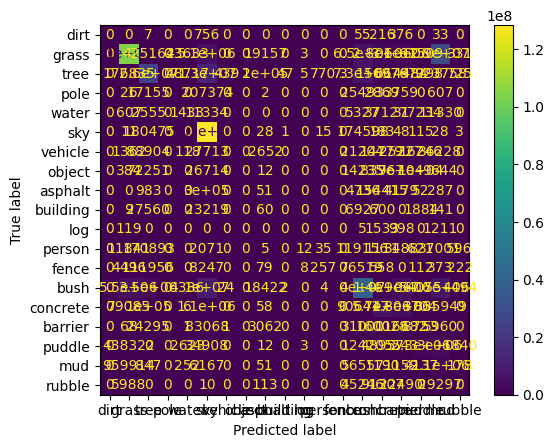

Class			IoU
dirt			0.00
grass			65.71
tree			49.08
pole			0.00
water			0.67
sky			81.11
vehicle			0.00
object			0.00
asphalt			0.01
building			0.00
log			0.00
person			0.01
fence			0.00
bush			44.95
concrete			30.99
barrier			0.84
puddle			37.46
mud			4.64
rubble			0.00


In [13]:
# Calculate metrics on the test set
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

with tf.device("/cpu:0"):
    dense_net = tf.keras.models.load_model("dense_net_final_proj.tf")
    dense_net.evaluate(test, batch_size=BATCH_SIZE)
    y_pred = dense_net.predict(x_test, batch_size=BATCH_SIZE)

reshape_x, reshape_y = y_test.shape[0] * y_test.shape[1] * y_test.shape[2], y_test.shape[3]
reshape_x, reshape_y = np.argmax(y_test.reshape(reshape_x, reshape_y), axis=-1), np.argmax(y_pred.reshape(reshape_x, reshape_y), axis=-1)

# Classification Report
print(classification_report(reshape_x, reshape_y, target_names=ontology_labels))

# Confusion Matrix
con_matrix = confusion_matrix(reshape_x, reshape_y)
con_disp = ConfusionMatrixDisplay(confusion_matrix=con_matrix, display_labels=ontology_labels)
plt.figure(figsize=(25, 25))
con_disp.plot()
plt.show()

# IoU Per Class
false_neg, false_pos = np.sum(con_matrix, axis=0), np.sum(con_matrix, axis=1)
print("Class\t\t\tIoU")
for i, clas in enumerate(ontology_labels):
    tp = con_matrix[i, i]
    iou = tp / (tp+ (false_pos[i] - tp) + (false_neg[i] - tp))
    print("%s\t\t\t%.2f" % (clas, iou * 100))

# Latest run: loss: 0.4106 - Top 1 Accuracy: 0.8647 - Top 3 Accuracy: 0.9856 - Top 5 Accuracy: 0.9921 - mean_io_u: 0.2326

In [ ]:
# # Reload previous best model ONLY UNCOMMENT TO LOAD A PREVIOUS MODEL
# from tensorflow import saved_model
# import tensorflow_hub as hub
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import models, optimizers, metrics

# dense_net = Sequential([hub.KerasLayer("Saved Models/best_dense_net")])

# model_metrics = [
#         metrics.TopKCategoricalAccuracy(k=1, name='Top 1 Accuracy'),
#         metrics.TopKCategoricalAccuracy(k=3, name='Top 3 Accuracy'),
#         metrics.TopKCategoricalAccuracy(k=5, name='Top 5 Accuracy'),
#         metrics.MeanIoU(num_classes=NUM_OF_CLASSES, sparse_y_true=False, sparse_y_pred=False, name="Mean IoU")
# ]

# dense_net.compile(loss="categorical_crossentropy", metrics=model_metrics)

In [ ]:
# Display 5 test images
with tf.device("/cpu:0"):
    for original, image in zip(x_test[0:10, :, :], dense_net.predict(x_test[0:10, :, :])):
        colored_image = np.argmax(image, axis=-1)
        colored_image = np.array(list(colors.values()))[colored_image]
        plt.imshow(original.astype(np.float32))
        plt.imshow(colored_image, alpha=0.5)
        plt.show()

In [ ]:
# # ONLY UNCOMMENT IF THIS IS THE BEST MODEL
# # TODO: Save figures for upscaling output, run in separate upscaler notebook
# from tensorflow import device

# with device("cpu:0"):
#     train_to_be_upscaled = dense_net.predict(train)
#     val_to_be_upscaled = dense_net.predict(val)
#     test_to_be_upscaled = dense_net.predict(test)

# np.savez("Processed Data/images_%d_predictions_%d_dense.npz" % (SPLIT, IMAGE_SIZE_REDUCE_FACTOR), train=train_to_be_upscaled, val=val_to_be_upscaled, test=test_to_be_upscaled)

In [ ]:
# ONLY UNCOMMENT IF THIS IS THE BEST MODEL
# from tensorflow import saved_model

# saved_model.save(dense_net, "Saved Models/best_dense_net")